In [50]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


In [51]:

#Choosing which years/files to read
el_csv_files = ["Day-ahead Prices_202301010000-202401010000.csv"]
electricity_df = pd.DataFrame()


#Processing electricity prices

for filename in el_csv_files:
    process_df = pd.read_csv(filename)
    electricity_df = pd.concat([electricity_df,process_df])

electricity_df = electricity_df[electricity_df["Day-ahead Price [EUR/MWh]"] != "-"].drop(labels = "BZN|CH", axis = 1)
electricity_df[['time_start','time_stop']] = electricity_df['MTU (CET/CEST)'].str.split(' - ',expand=True)
electricity_df["time_start"] = pd.to_datetime(electricity_df["time_start"], format = "%d.%m.%Y %H:%M")
electricity_df["time_stop"] = pd.to_datetime(electricity_df["time_stop"], format = "%d.%m.%Y %H:%M")
electricity_df["Day-ahead Price [EUR/MWh]"] = pd.to_numeric(electricity_df["Day-ahead Price [EUR/MWh]"])
    
start_date = electricity_df.sort_values("time_start")["time_start"].values[0]
end_date = electricity_df["time_start"].values[-1]

interval_size_int = 4
interval_size = pd.Timedelta(hours=interval_size_int)

electricity_df["average_electricity_price [EUR/MW]"] = pd.Series()
prices_series = pd.Series()
date_iterator = start_date
while date_iterator < end_date:
    df = electricity_df [(electricity_df["time_start"] >= date_iterator) & (electricity_df["time_start"]< date_iterator + interval_size)]
    #Finding the average 4 hour price in EUR/MW
    avg_price = df["Day-ahead Price [EUR/MWh]"].sum()
    indices = list(df.index.values)
    electricity_df.loc[indices[0]:indices[-1],"average_electricity_price [EUR/MW]"] = avg_price 
    date_iterator = date_iterator+interval_size
electricity_df = electricity_df[electricity_df["time_start"].dt.hour%4 ==0].drop(labels = ["MTU (CET/CEST)", "Day-ahead Price [EUR/MWh]","time_stop", "Currency"], axis =1)
electricity_df

,time_start,average_electricity_price [EUR/MW]
0,2023-01-01 00:00:00,-18.92
4,2023-01-01 04:00:00,-39.85
8,2023-01-01 08:00:00,-7.04
12,2023-01-01 12:00:00,14.76
16,2023-01-01 16:00:00,119.95
...,...,...
7325,2023-11-02 04:00:00,180.58
7329,2023-11-02 08:00:00,260.94
7333,2023-11-02 12:00:00,254.87
7337,2023-11-02 16:00:00,364.75


In [52]:
#This block creates a dataframe with weekly "average" electricity prices
# We need to cut of the first and last weeks because we operate by per MW
#Should we include other dates as well?
#Filtering out all entries that are not a full week in lenght, i.e., first and last week entries

electricity_df["calendar_week"] = electricity_df["time_start"].apply(lambda date: date.isocalendar()[1])

weekly_el_df = pd.DataFrame()
weekly_el_df = electricity_df.apply(lambda row: electricity_df[electricity_df["calendar_week"] == row["calendar_week"]].iloc[0], axis = 1).drop_duplicates()
weekly_el_df = weekly_el_df.merge(electricity_df.groupby("calendar_week",as_index=True).size().rename("weekdays_counter"), left_on = "calendar_week", right_on = "calendar_week")

weekly_el_df = weekly_el_df[weekly_el_df["weekdays_counter"] == 24/4*7].drop("weekdays_counter", axis = 1)
weekly_el_df["average_electricity_price [EUR/MW]"] = weekly_el_df.apply(lambda row: electricity_df[electricity_df["calendar_week"] == row["calendar_week"]]["average_electricity_price [EUR/MW]"].sum(), axis = 1)

#weekly_el_df["average_electricity_price [EUR/MW]"] = electricity_df.groupby("calendar_week", as_index = False)["average_electricity_price [EUR/MW]"].sum()
#electricity_df = electricity_df[electricity_df["number_of_weekly_periods"] == 24/4*7]
weekly_el_df

,time_start,average_electricity_price [EUR/MW],calendar_week
1,2023-01-02,22767.93,1
2,2023-01-09,27361.52,2
3,2023-01-16,28497.32,3
4,2023-01-23,30243.65,4
5,2023-01-30,26580.49,5
6,2023-02-06,27639.74,6
7,2023-02-13,25513.13,7
8,2023-02-20,24046.05,8
9,2023-02-27,25447.78,9
10,2023-03-06,22593.03,10


In [53]:
#processing ancillary bids to find average bid, max bid, and min bid per 4-hour session

ancillary_df = pd.DataFrame()

an_csv_files = ["2023-PRL-SRL-TRL-Ergebnis.csv"]
ancillary_df = pd.DataFrame()


for filename in an_csv_files:
    process_df = pd.read_csv(filename, sep = ";", low_memory=False)
    ancillary_df = pd.concat([ancillary_df,process_df])


#specifying and filtering by ancillary service type
ancillary_df = ancillary_df[ancillary_df["Beschreibung"].str[-4:-1] == "SRL"]
display(ancillary_df)
ancillary_df["type"] = ancillary_df["Beschreibung"].str[-4:]
ancillary_df["week"] = ((ancillary_df["Ausschreibung"] + " ").str[9:11])
ancillary_df["year"] = ((ancillary_df["Ausschreibung"]).str[4:6].astype(int) + 2000).astype(str)
ancillary_df["time_start"] = ancillary_df.apply(lambda row: datetime.strptime(row["year"] + row["week"] + '-1', "%Y%W-%w"), axis = 1)





#We see by unhashing the line below that volume that cannot be parted is relatively small so we can look away from that in the first place
#print(ancillary_df[ancillary_df["Teilbarkeit"] != "Ja"]["Angebotenes Volumen"].sum()/ancillary_df["Angebotenes Volumen"].sum())

display(ancillary_df.keys())
#We are at the moment only keeping the 'Leisungspreis' out of the prices
ancillary_df.drop(columns=['Ausschreibung', 'Beschreibung', 'Angebotenes Volumen', 'Einheit','Einheit.1',
        'Einheit.2',
       'Kosten', 'Einheit.3', 'Preis', 'Einheit.4', 'Angebotspreis',
       'Einheit.5'],axis=1, inplace=True)

#ancillary_df.drop(columns=ancillary_df.columns[])

#Unhash line below to get only bids in Switzerland
#ancillary_df = ancillary_df[ancillary_df["Land"] == "CH"]

#Renaming columns
new_column_names = ["volume_sold [MW]","ancillary_price [EUR/MW]", "country", "divisibility"]
ancillary_df = ancillary_df.rename(columns=dict(zip(["Zugesprochenes Volumen","Leistungspreis","Land","Teilbarkeit"],new_column_names)))

#Echange rate, from 0.9753. Yearly average 28 nov 2022 to 28 nov 2023
CHF_to_EUR = 1/0.9753
ancillary_df["ancillary_price [EUR/MW]"] = ancillary_df["ancillary_price [EUR/MW]"]*CHF_to_EUR
display(ancillary_df)

#ancillary_df = ancillary_df.groupby(by = ["time_start","ancillary_price [EUR/MW]","divisibility"], as_index = False).sum()
ancillary_df = ancillary_df.merge(right = weekly_el_df, on="time_start").sort_values("ancillary_price [EUR/MW]",ascending = False).sort_values("time_start")
ancillary_df


,Ausschreibung,Beschreibung,Angebotenes Volumen,Einheit,Zugesprochenes Volumen,Einheit.1,Leistungspreis,Einheit.2,Kosten,Einheit.3,Preis,Einheit.4,Land,Angebotspreis,Einheit.5,Teilbarkeit
437464,SRL_22_KW52,Secondary control Auction SRL+,10,MW,10,MW,3880.8,CHF/MW,38808.0,CHF,23.10,CHF/MWh*,CH,23.10,CHF/MWh*,NaN
437465,SRL_22_KW52,Secondary control Auction SRL+,10,MW,10,MW,4828.0,CHF/MW,48280.0,CHF,28.74,CHF/MWh*,CH,28.74,CHF/MWh*,NaN
437466,SRL_22_KW52,Secondary control Auction SRL+,12,MW,12,MW,3511.2,CHF/MW,42134.4,CHF,20.90,CHF/MWh*,CH,20.90,CHF/MWh*,NaN
437467,SRL_22_KW52,Secondary control Auction SRL+,12,MW,12,MW,4788.0,CHF/MW,57456.0,CHF,28.50,CHF/MWh*,CH,28.50,CHF/MWh*,NaN
437468,SRL_22_KW52,Secondary control Auction SRL+,16,MW,16,MW,3511.2,CHF/MW,56179.2,CHF,20.90,CHF/MWh*,CH,20.90,CHF/MWh*,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439704,SRL_23_KW45,Secondary control Auction SRL-,20,MW,20,MW,5124.0,CHF/MW,102480.0,CHF,30.50,CHF/MWh*,CH,30.50,CHF/MWh*,NaN
439705,SRL_23_KW45,Secondary control Auction SRL-,7,MW,7,MW,5223.0,CHF/MW,36561.0,CHF,31.09,CHF/MWh*,CH,31.09,CHF/MWh*,NaN
439706,SRL_23_KW45,Secondary control Auction SRL-,32,MW,32,MW,5346.0,CHF/MW,171072.0,CHF,31.82,CHF/MWh*,CH,31.82,CHF/MWh*,NaN
439707,SRL_23_KW45,Secondary control Auction SRL-,30,MW,30,MW,6205.0,CHF/MW,186150.0,CHF,36.93,CHF/MWh*,CH,36.93,CHF/MWh*,NaN


Index(['Ausschreibung', 'Beschreibung', 'Angebotenes Volumen', 'Einheit',
       'Zugesprochenes Volumen', 'Einheit.1', 'Leistungspreis', 'Einheit.2',
       'Kosten', 'Einheit.3', 'Preis', 'Einheit.4', 'Land', 'Angebotspreis',
       'Einheit.5', 'Teilbarkeit', 'type', 'week', 'year', 'time_start'],
      dtype='object')

,volume_sold [MW],ancillary_price [EUR/MW],country,divisibility,type,week,year,time_start
437464,10,3979.083359,CH,NaN,SRL+,52,2022,2022-12-26
437465,10,4950.271711,CH,NaN,SRL+,52,2022,2022-12-26
437466,12,3600.123039,CH,NaN,SRL+,52,2022,2022-12-26
437467,12,4909.258690,CH,NaN,SRL+,52,2022,2022-12-26
437468,16,3600.123039,CH,NaN,SRL+,52,2022,2022-12-26
...,...,...,...,...,...,...,...,...
439704,20,5253.768071,CH,NaN,SRL-,45,2023,2023-11-06
439705,7,5355.275300,CH,NaN,SRL-,45,2023,2023-11-06
439706,32,5481.390341,CH,NaN,SRL-,45,2023,2023-11-06
439707,30,6362.144981,CH,NaN,SRL-,45,2023,2023-11-06


,volume_sold [MW],ancillary_price [EUR/MW],country,divisibility,type,week,year,time_start,average_electricity_price [EUR/MW],calendar_week
32,5,18835.281452,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1
44,50,12735.568543,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1
8,10,15379.883113,CH,NaN,SRL+,01,2023,2023-01-02,22767.93,1
15,9,10268.430227,CH,NaN,SRL+,01,2023,2023-01-02,22767.93,1
16,5,10268.430227,CH,NaN,SRL+,01,2023,2023-01-02,22767.93,1
...,...,...,...,...,...,...,...,...,...,...
2102,25,4069.517072,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43
2078,10,1093.396904,CH,NaN,SRL+,43,2023,2023-10-23,17517.01,43
2106,5,4074.643699,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43
2084,100,1116.169384,CH,NaN,SRL+,43,2023,2023-10-23,17517.01,43


In [54]:
#TODO: change currency, look at average, price functions, recalculating the currencies,
#calculating and plotting average ancillary price
#ancillary_df["average_ancillary_price [EUR/MW]"] = 
ancillary_df["weighted_prices"] = ancillary_df["ancillary_price [EUR/MW]"]*ancillary_df["volume_sold [MW]"]
average_ancillary_prices  = ancillary_df.groupby(by = ["time_start","type"])["weighted_prices"].sum()/ancillary_df.groupby(by = ["time_start","type"])["volume_sold [MW]"].sum()
ancillary_df = ancillary_df.drop("weighted_prices", axis=1)
average_ancillary_prices = average_ancillary_prices.reset_index().rename(columns={0:'average_ancillary_price [EUR/MW]'})
display(average_ancillary_prices)
ancillary_df = ancillary_df.merge(average_ancillary_prices, left_on = ["type","time_start"], right_on = ["type","time_start"])
ancillary_df

,time_start,type,average_ancillary_price [EUR/MW]
0,2023-01-02,SRL+,9358.610386
1,2023-01-02,SRL-,15974.795494
2,2023-01-09,SRL+,11527.577396
3,2023-01-09,SRL-,9771.259637
4,2023-01-16,SRL+,13266.857643
...,...,...,...
81,2023-10-09,SRL-,3002.822035
82,2023-10-16,SRL+,1101.658552
83,2023-10-16,SRL-,4070.267949
84,2023-10-23,SRL+,1124.285997


,volume_sold [MW],ancillary_price [EUR/MW],country,divisibility,type,week,year,time_start,average_electricity_price [EUR/MW],calendar_week,average_ancillary_price [EUR/MW]
0,5,18835.281452,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1,15974.795494
1,50,12735.568543,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1,15974.795494
2,12,18680.406029,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1,15974.795494
3,5,16924.023377,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1,15974.795494
4,5,16924.023377,CH,NaN,SRL-,01,2023,2023-01-02,22767.93,1,15974.795494
...,...,...,...,...,...,...,...,...,...,...,...
2103,5,4643.904440,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43,4569.566154
2104,15,4039.372501,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43,4569.566154
2105,5,4049.707782,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43,4569.566154
2106,25,4069.517072,CH,NaN,SRL-,43,2023,2023-10-23,17517.01,43,4569.566154


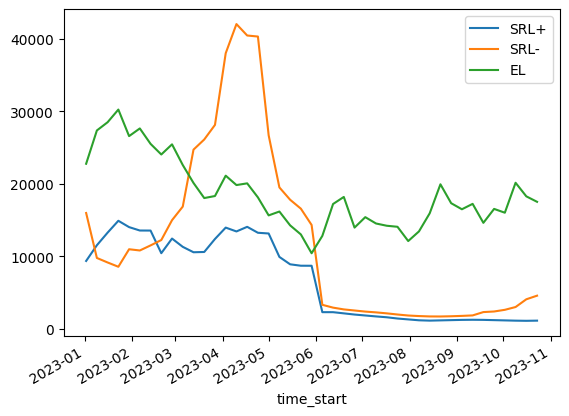

In [55]:
#Plotting the prices against each other for comparison
ax = ancillary_df[ancillary_df["type"] == "SRL+"].plot( x = "time_start", y ="average_ancillary_price [EUR/MW]")
ancillary_df[ancillary_df["type"] == "SRL-"].plot(ax = ax, x = "time_start", y= "average_ancillary_price [EUR/MW]")
ancillary_df.plot(ax = ax, x = "time_start", y = "average_electricity_price [EUR/MW]")
ax.legend(["SRL+","SRL-","EL"])

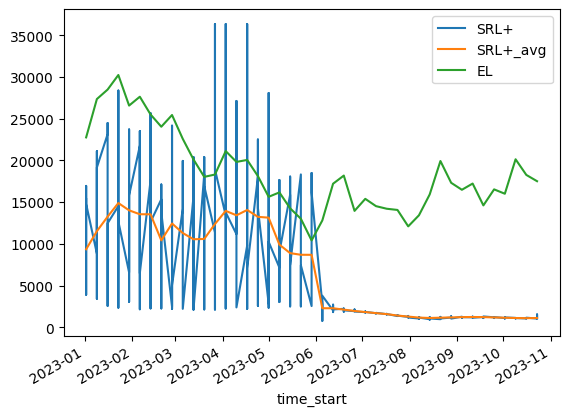

In [56]:
#Plotting to vizualise how the average lies in range of bid prices
ax_plus = ancillary_df[ancillary_df["type"] == "SRL+"].plot( x = "time_start", y ="ancillary_price [EUR/MW]")
ancillary_df[ancillary_df["type"] == "SRL+"].plot(ax = ax_plus, x = "time_start", y= "average_ancillary_price [EUR/MW]")
ancillary_df.plot(ax = ax_plus, x = "time_start", y = "average_electricity_price [EUR/MW]")
ax_plus.legend(["SRL+","SRL+_avg", "EL"])


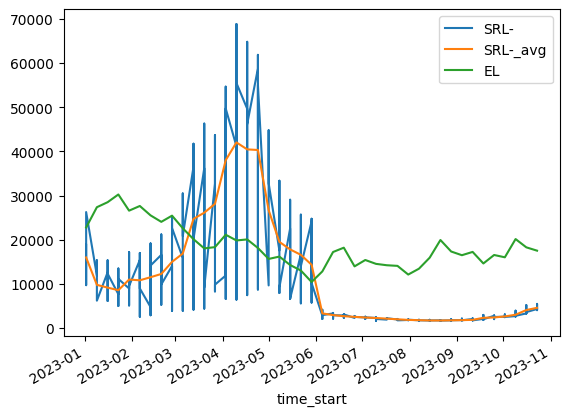

In [57]:
ax_minus = ancillary_df[ancillary_df["type"] == "SRL-"].plot( x = "time_start", y ="ancillary_price [EUR/MW]")
ancillary_df[ancillary_df["type"] == "SRL-"].plot(ax = ax_minus, x = "time_start", y= "average_ancillary_price [EUR/MW]")
ancillary_df.plot(ax = ax_minus, x = "time_start", y = "average_electricity_price [EUR/MW]")
ax_minus.legend(["SRL-","SRL-_avg", "EL"])


In [58]:
#Note: Assumptions: deficit penalty is not taken into consideration. Average weekly prices are used, although swissgrid uses prices for 15 min intervals


In [70]:
class powerPlant:
    def __init__(self, P_min, P_max, reservoir):
        if (P_min > P_max):
            raise ValueError("miniaml capacity cannot be larger than the maximal capacity")
        elif (reservoir < 0):
            raise ValueError("reservoir cannot be smaller than 0!")
        else:
            self.P_min = P_min
            self.P_max = P_max
            self.P_mid = (P_min + P_max) / 2
            self.reservoir = reservoir

    def priceFunction(self, P, S_el, S_srl_pos,S_srl_neg):
        utilization_factor = 0.05
        #First calculating for the minimal capacity
        if (self.P_min <= P and P <= self.P_max):
            baseline = self.P_min*S_el
            price_srl_neg = baseline + (P-self.P_min)*(S_srl_neg + utilization_factor*self.long_price(S_el,S_srl_neg,"-") + (1-utilization_factor)*S_el)
            price_el = baseline + (P-self.P_min)*S_el
            production_price = max(price_el,price_srl_neg)
            price_srl_plus = baseline + (self.P_max - P)*(S_srl_pos + utilization_factor*self.long_price(S_el,S_srl_neg))
            #print(srl_plus_price,production_price,price_srl_neg,price_el)
            return price_srl_plus + production_price
        elif (P == 0):

            return 0
        else:
            raise ValueError("Operating outside of the scope of the function")
        
    def long_price(self,S_el,S_srl, mode):
        #Returns surplus price in EUR/MW
        a1  = 1.1
        a2  =0.9
        if mode == "-":
            B = min(S_el,S_srl)
        CHF_to_EUR = 1/0.9753
        P2 = 0.5/100*1000*CHF_to_EUR*7*24
        if B-P2 <0:
            a = a1
        else: 
            a = a2
        print((B-P2)*a)
        return (B-P2)*a

124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
124.85389111042754
[40093.64041833283, 40543.64041833282, 40993.64041833283, 41443.64041833282, 41893.64041833283, 42343.64041833282, 42793.64041833283, 43243.64041833283, 43693.64041833283, 44143.64041833282, 44593.64041833283, 45043.64041833283, 45493.64041833283, 45943.64041833283, 46393.64041833283]


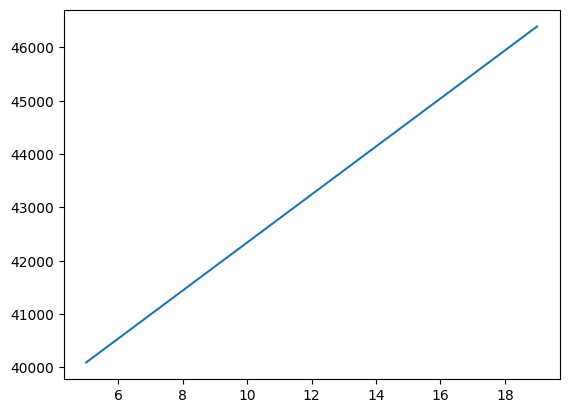

In [72]:
pp = powerPlant(5,20,100)
P = np.arange(5,20)
P_func = []
for i in P:
    P_func += [pp.priceFunction(i,1000,2000,1500)]
print(P_func)
plt.plot(P,P_func)